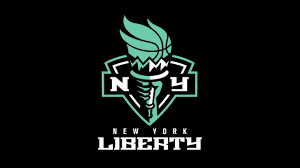
# Game Attendance
## New York Liberty

## Overview

The 2022 season was the highest viewed season, with an average of 379 thousand viewers, so the New York Liberty is curious how the WNBA's rising popualarity will affect their game by game attendance.

In [61]:
from random import gauss as gs
import pandas as pd
import numpy as np
from numpy import log, sqrt
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pylab import rcParams
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import autocorrelation_plot

import itertools

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

## Business & Data Understanding

Explain your stakeholder audience and dataset choice here

In [2]:
NYL_Final_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/WNBA-Viewership/Team_CSVs/Final_csv.csv')
NYL_Final_df

,Unnamed: 0.1,Unnamed: 0,Date,Opponent,Segment,Arena,Location,Attendance
0,0,0,"June 29, 1997",Phoenix Mercury,Regular season,Madison Square Garden,"New York, NY",17780
1,1,1,"July 2, 1997",Houston Comets,Regular season,Madison Square Garden,"New York, NY",8792
2,2,2,"July 10, 1997",Charlotte Sting,Regular season,Madison Square Garden,"New York, NY",9951
3,3,3,"July 15, 1997",Cleveland Rockers,Regular season,Madison Square Garden,"New York, NY",8554
4,4,4,"July 17, 1997",Utah Starzz,Regular season,Madison Square Garden,"New York, NY",9017
...,...,...,...,...,...,...,...,...
892,356,10,"July 5, 2018",New York Liberty,Regular season,Capital One Arena,"Washington, DC",4674
893,379,13,"August 25, 2019",New York Liberty,Regular season,Entertainment and Sports Arena,"Washington, DC",4200
894,390,2,"May 21, 2021",New York Liberty,Regular season,Entertainment and Sports Arena,"Washington, DC",1050
895,409,5,"June 3, 2022",New York Liberty,Regular season,Entertainment and Sports Arena,"Washington, DC",3857


In [3]:
NYL_Final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  897 non-null    int64 
 1   Unnamed: 0    897 non-null    int64 
 2   Date          897 non-null    object
 3   Opponent      897 non-null    object
 4   Segment       897 non-null    object
 5   Arena         897 non-null    object
 6   Location      897 non-null    object
 7   Attendance    897 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 56.2+ KB


In [4]:
NYL_Final_df['Date'] = pd.to_datetime(NYL_Final_df['Date'])
NYL_Final_df['year'] = NYL_Final_df['Date'].dt.year

<Axes: xlabel='year', ylabel='Attendance'>

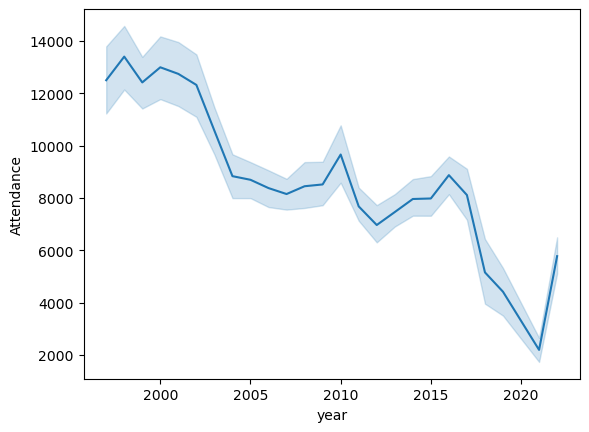

In [5]:
sns.lineplot(x = NYL_Final_df['year'], y = NYL_Final_df['Attendance'])

In [6]:
NYL_Final_df.sort_values(by = 'Date', inplace = True)
NYL_Final_df

,Unnamed: 0.1,Unnamed: 0,Date,Opponent,Segment,Arena,Location,Attendance,year
687,0,0,1997-06-21,New York Liberty,Regular season,Great Western Forum,"Los Angeles, CA",14284,1997
784,0,0,1997-06-23,New York Liberty,Regular season,ARCO Arena,"Sacramento, CA",15259,1997
621,1,1,1997-06-26,New York Liberty,Regular season,Compaq Center,"Houston, TX",8931,1997
0,0,0,1997-06-29,Phoenix Mercury,Regular season,Madison Square Garden,"New York, NY",17780,1997
1,1,1,1997-07-02,Houston Comets,Regular season,Madison Square Garden,"New York, NY",8792,1997
...,...,...,...,...,...,...,...,...,...
478,255,17,2022-08-12,New York Liberty,Regular season,Gateway Center Arena,"Atlanta, GA",3138,2022
449,449,17,2022-08-14,Atlanta Dream,Regular season,Barclays Center,"Brooklyn, NY",7561,2022
528,285,18,2022-08-17,New York Liberty,First Round,Wintrust Arena,"Chicago, IL",7524,2022
529,286,19,2022-08-20,New York Liberty,First Round,Wintrust Arena,"Chicago, IL",7732,2022


In [7]:
NYL_Final_ts = NYL_Final_df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'Opponent', 'Segment', 'Arena', 'Location',\
                                 'year'], axis = 1)
NYL_Final_ts.head()

,Date,Attendance
687,1997-06-21,14284
784,1997-06-23,15259
621,1997-06-26,8931
0,1997-06-29,17780
1,1997-07-02,8792


In [8]:
NYL_Final_ts['Date'] = pd.to_datetime(NYL_Final_ts['Date'])

In [9]:
NYL_Final_ts.set_index('Date', inplace = True)
NYL_Final_ts.head()

,Attendance
Date,
1997-06-21,14284
1997-06-23,15259
1997-06-26,8931
1997-06-29,17780
1997-07-02,8792


In [35]:
if (NYL_Final_ts['Attendance'] <= 0).any():
    NYL_Final_ts.loc[NYL_Final_ts['Attendance'] <= 0, 'Attendance'] = np.nan
    NYL_Final_ts.dropna(inplace = True)

In [36]:
NYL_Final_ts_fill = NYL_Final_ts.interpolate()
NYL_Final_ts_fill.head(10)

,Attendance
Date,
1997-06-21,119.515689
1997-06-23,123.527325
1997-06-26,94.503968
1997-06-29,133.341666
1997-07-02,93.765665
1997-07-04,101.187944
1997-07-05,87.686943
1997-07-07,117.179350
1997-07-09,94.408686


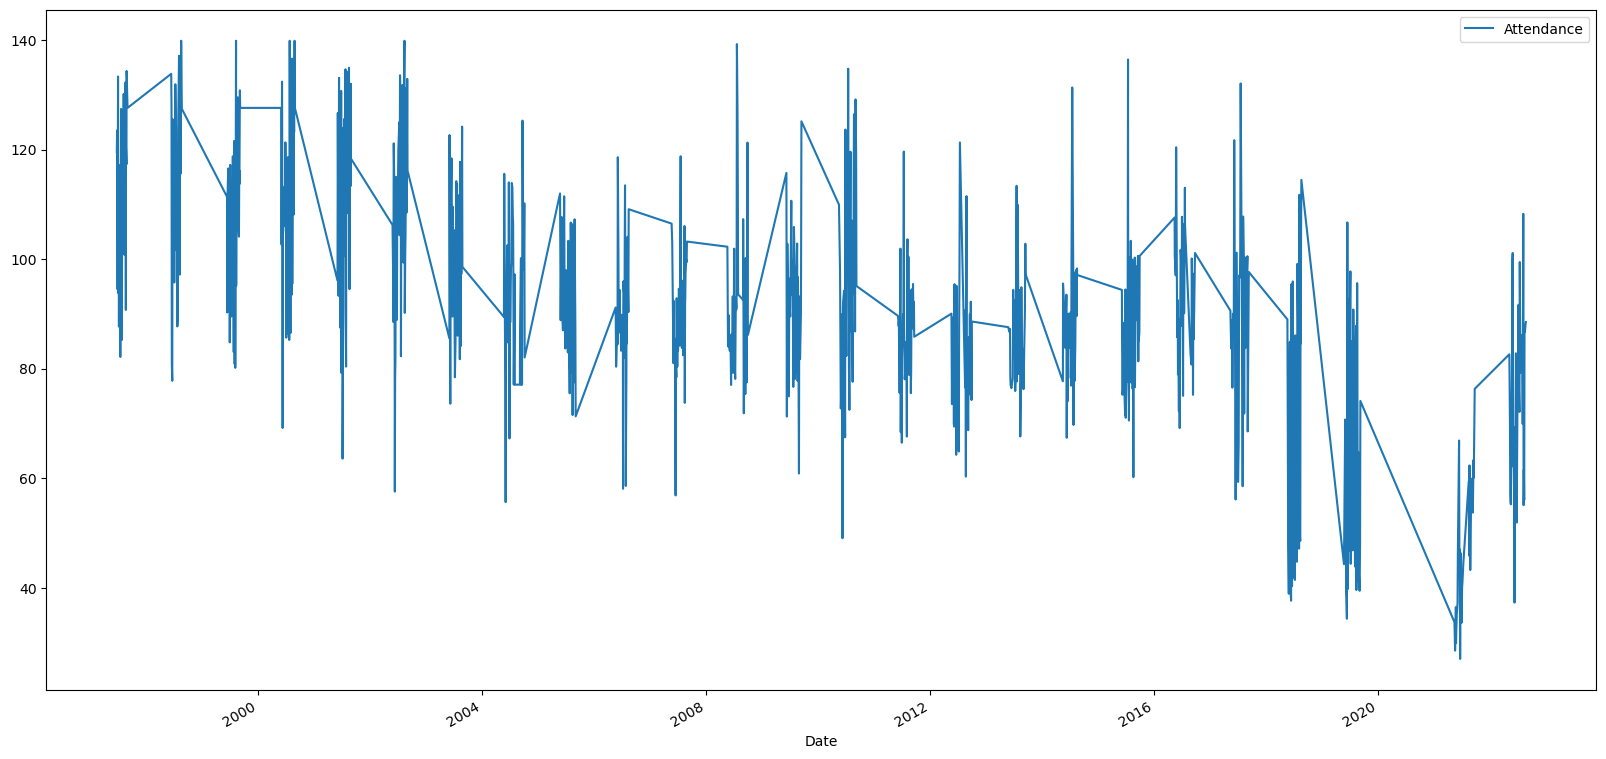

In [39]:
NYL_Final_ts_fill.plot(figsize = (20,10));

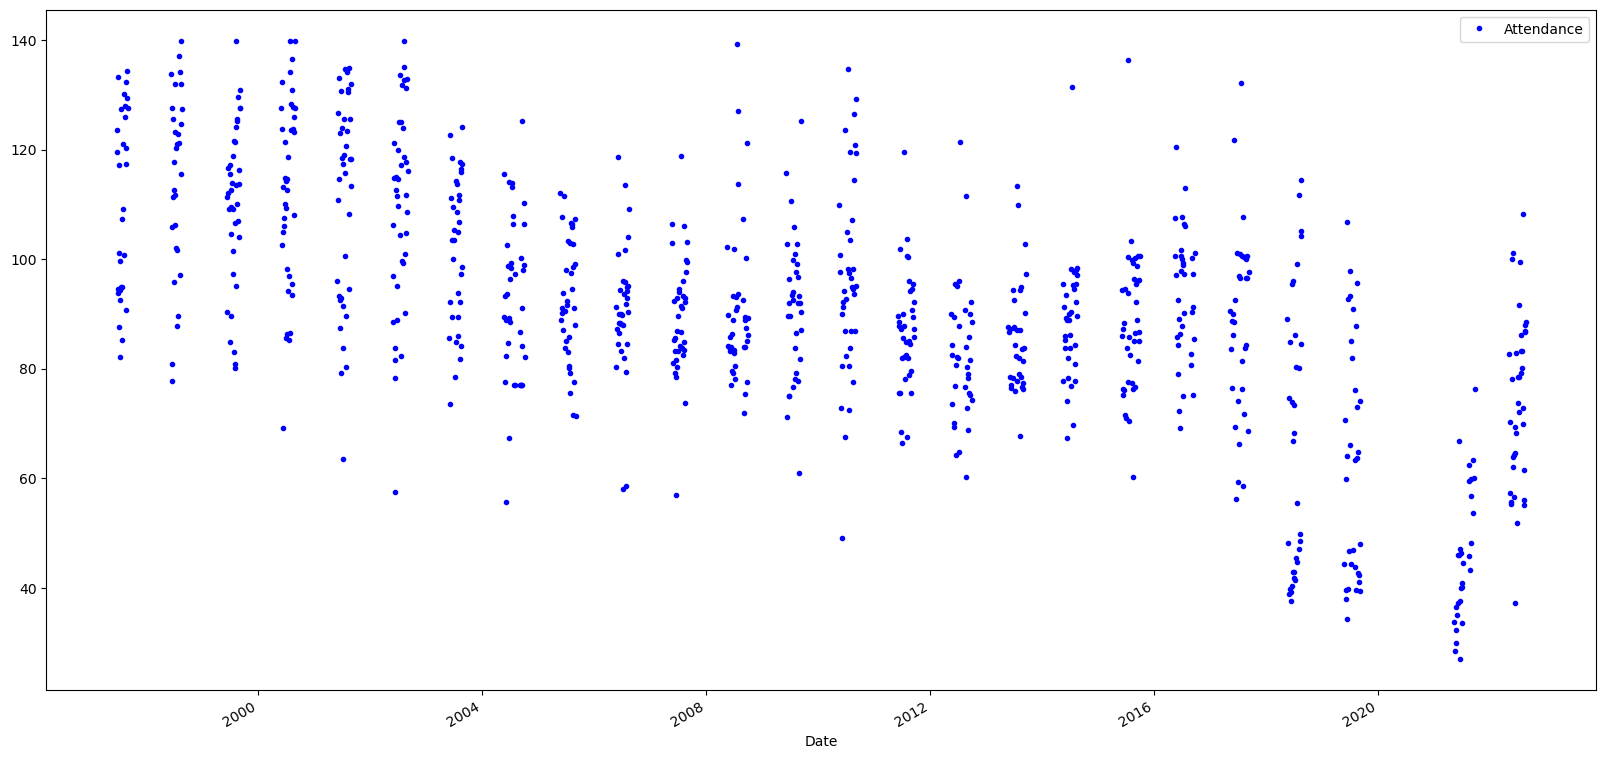

In [40]:
NYL_Final_ts_fill.plot(figsize = (20,10), style = '.b');

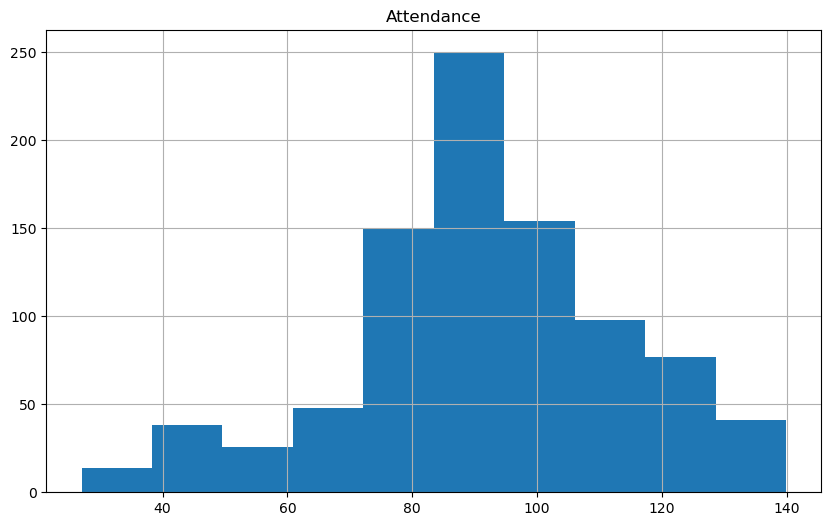

In [41]:
NYL_Final_ts_fill.hist(figsize = (10,6));

In [42]:
dftest = adfuller(NYL_Final_ts_fill)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.312931
p-value                          0.167831
#Lags Used                      15.000000
Number of Observations Used    880.000000
Critical Value (1%)             -3.437803
Critical Value (5%)             -2.864830
Critical Value (10%)            -2.568522
dtype: float64


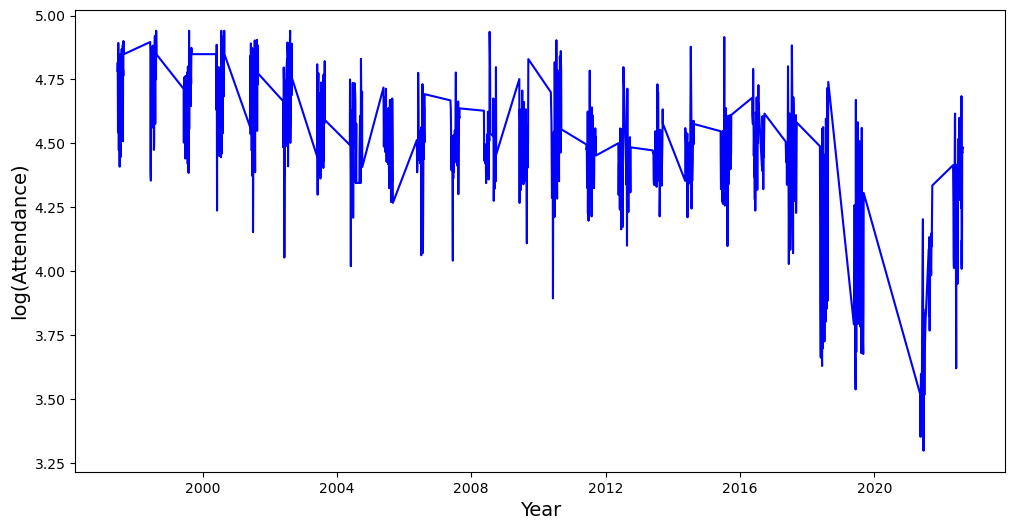

In [37]:
log_transform = log(NYL_Final_ts_fill)
fig = plt.figure(figsize = (12,6))
plt.plot(log_transform, color = 'blue')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('log(Attendance)', fontsize = 14)
plt.show()

In [38]:
dftest = adfuller(log_transform)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.330193
p-value                          0.162415
#Lags Used                      15.000000
Number of Observations Used    880.000000
Critical Value (1%)             -3.437803
Critical Value (5%)             -2.864830
Critical Value (10%)            -2.568522
dtype: float64


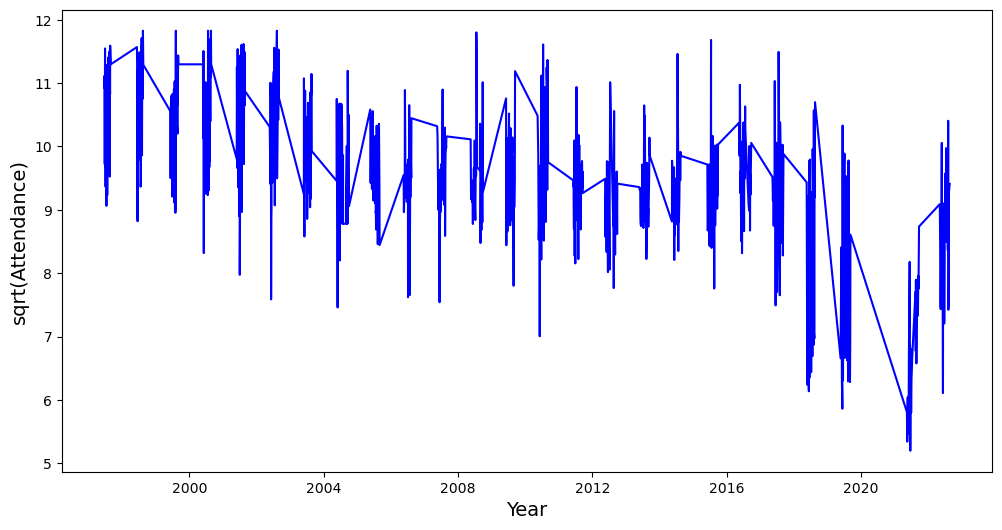

In [43]:
sqrt_transform = NYL_Final_ts = sqrt(NYL_Final_ts_fill)
fig = plt.figure(figsize = (12,6))
plt.plot(sqrt_transform, color = 'blue')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('sqrt(Attendance)', fontsize = 14)
plt.show()

In [44]:
dftest = adfuller(sqrt_transform)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.299988
p-value                          0.171972
#Lags Used                      15.000000
Number of Observations Used    880.000000
Critical Value (1%)             -3.437803
Critical Value (5%)             -2.864830
Critical Value (10%)            -2.568522
dtype: float64


In [45]:
roll_mean = NYL_Final_ts_fill.rolling(window = 4, center = False).mean()
roll_std = NYL_Final_ts_fill.rolling(window = 4, center = False).std()

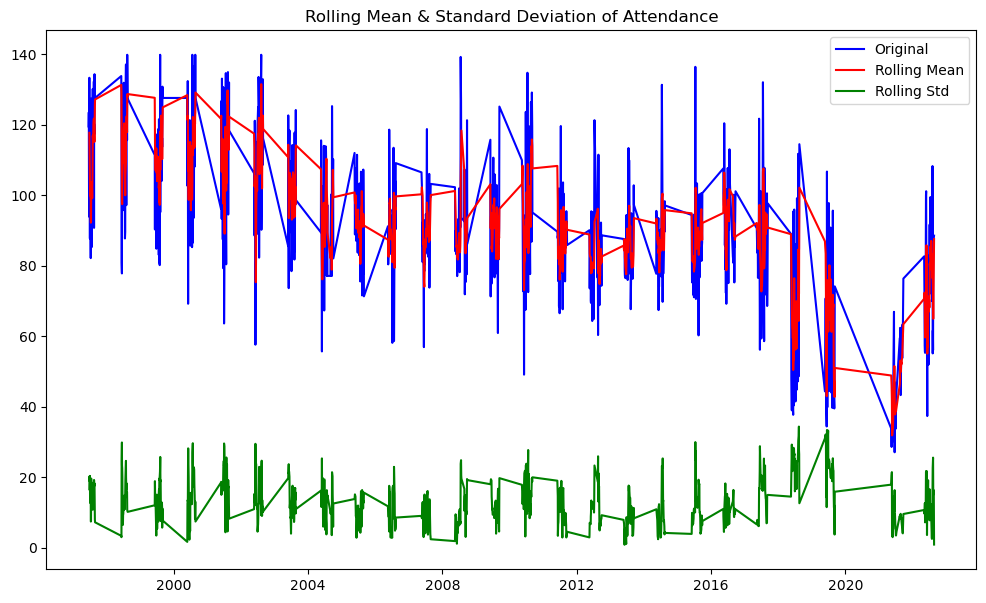

In [46]:
fig = plt.figure(figsize = (12,7))
plt.plot(NYL_Final_ts_fill, color = 'blue', label = 'Original')
plt.plot(roll_mean, color = 'red', label = 'Rolling Mean')
plt.plot(roll_std, color = 'green', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation of Attendance')
plt.show(block = False)

In [47]:
NYL_Final_ts_fill_minus_roll_mean = NYL_Final_ts_fill - roll_mean
NYL_Final_ts_fill_minus_roll_mean.head(10)

,Attendance
Date,
1997-06-21,NaN
1997-06-23,NaN
1997-06-26,NaN
1997-06-29,15.619504
1997-07-02,-17.518991
1997-07-04,-4.511867
1997-07-05,-16.308612
1997-07-07,17.224374
1997-07-09,-5.707045


In [48]:
NYL_Final_ts_fill_minus_roll_mean.dropna(inplace = True)

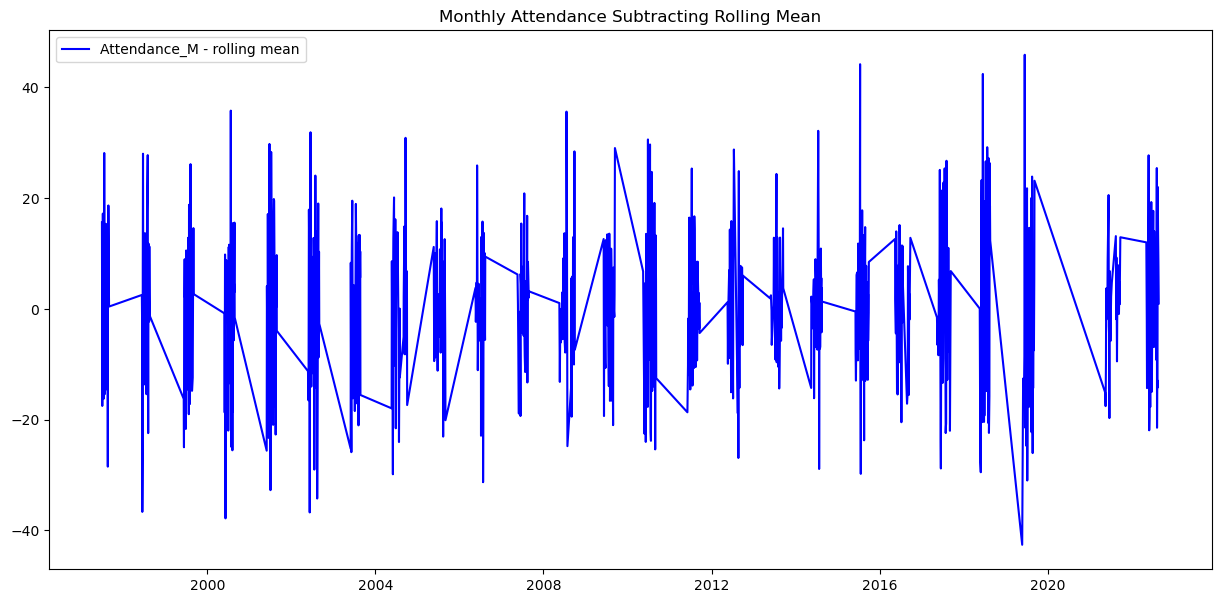

In [49]:
fig = plt.figure(figsize = (15,7))
plt.plot(NYL_Final_ts_fill_minus_roll_mean, color = 'blue',label = 'Attendance_M - rolling mean')
plt.legend(loc = 'best')
plt.title('Monthly Attendance Subtracting Rolling Mean')
plt.show(block = False)

In [50]:
dftest = adfuller(NYL_Final_ts_fill_minus_roll_mean)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.018499e+01
p-value                        6.543978e-18
#Lags Used                     1.700000e+01
Number of Observations Used    8.750000e+02
Critical Value (1%)           -3.437846e+00
Critical Value (5%)           -2.864849e+00
Critical Value (10%)          -2.568532e+00
dtype: float64


In [51]:
NYL_Final_ts_fill_diff = NYL_Final_ts_fill.diff(periods = 1)
NYL_Final_ts_fill_diff.head(10)

,Attendance
Date,
1997-06-21,NaN
1997-06-23,4.011636
1997-06-26,-29.023357
1997-06-29,38.837698
1997-07-02,-39.576001
1997-07-04,7.422279
1997-07-05,-13.501001
1997-07-07,29.492407
1997-07-09,-22.770664


In [52]:
NYL_Final_ts_fill_diff.dropna(inplace = True)

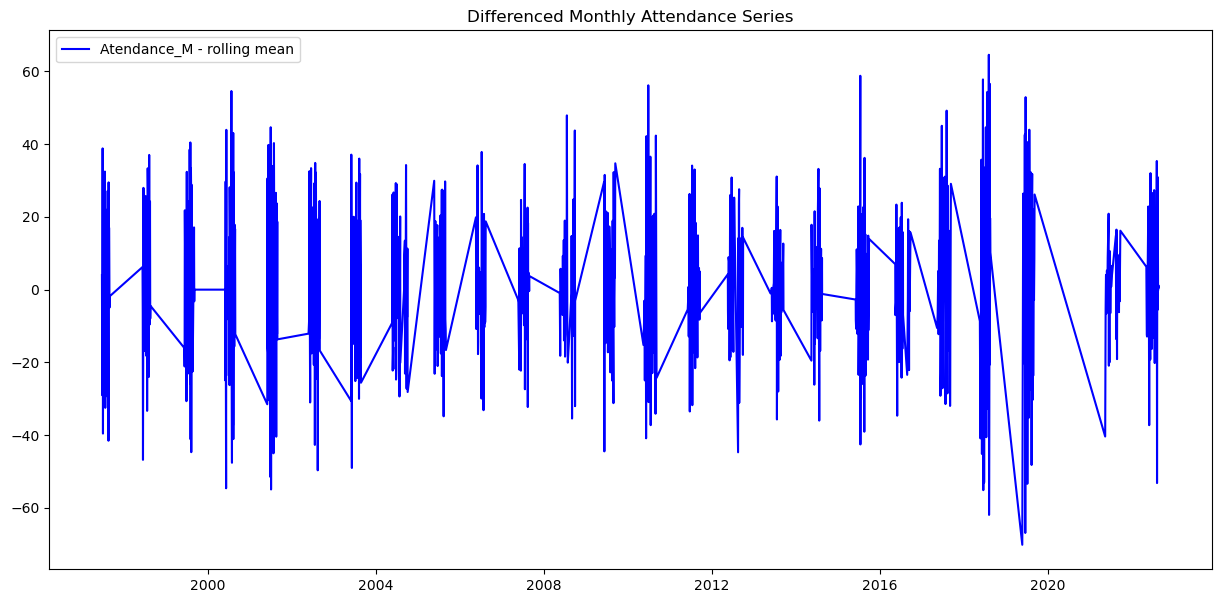

In [53]:
fig = plt.figure(figsize = (15,7))
plt.plot(NYL_Final_ts_fill_diff, color = 'blue',label = 'Atendance_M - rolling mean')
plt.legend(loc = 'best')
plt.title('Differenced Monthly Attendance Series')
plt.show(block = False)

In [54]:
dftest = adfuller(NYL_Final_ts_fill_diff)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.256138e+01
p-value                        2.098931e-23
#Lags Used                     1.400000e+01
Number of Observations Used    8.800000e+02
Critical Value (1%)           -3.437803e+00
Critical Value (5%)           -2.864830e+00
Critical Value (10%)          -2.568522e+00
dtype: float64


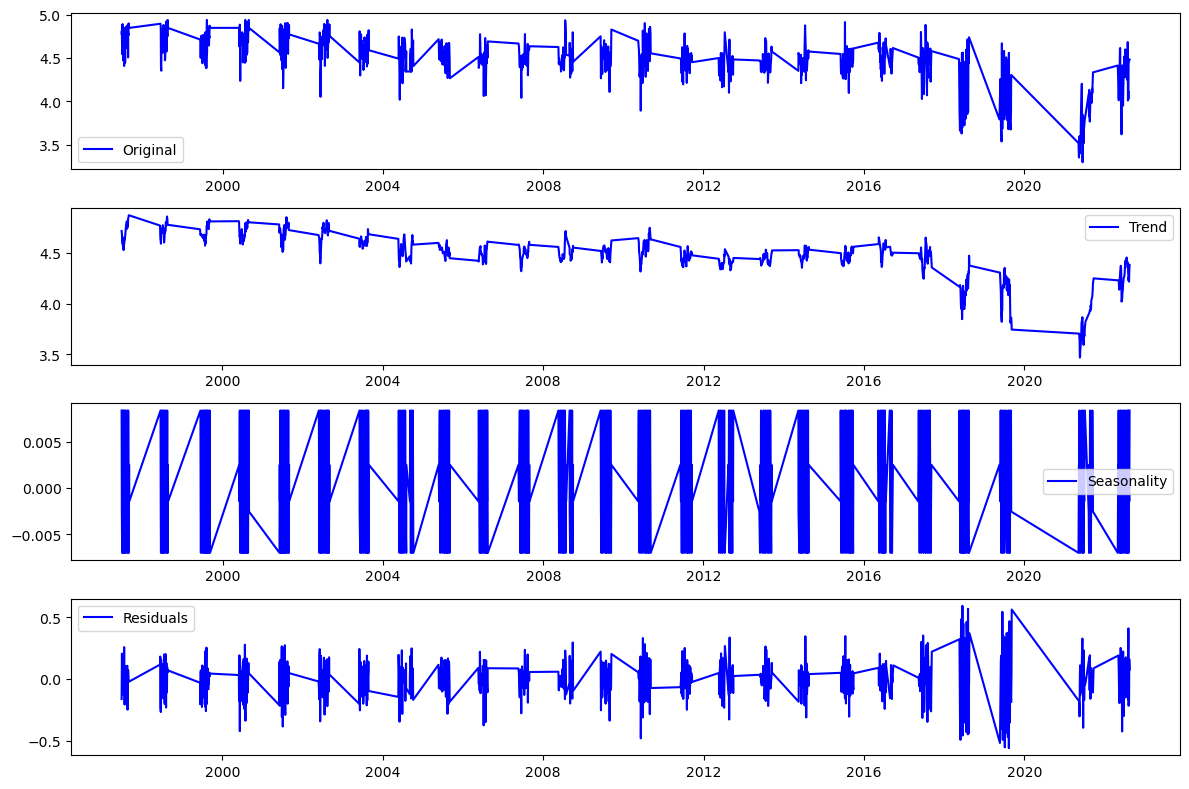

In [137]:
decomposition = seasonal_decompose(np.log(NYL_Final_ts_fill), period = 5)
 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (12,8))
plt.subplot(411)
plt.plot(np.log(NYL_Final_ts_fill), label = 'Original', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal,label = 'Seasonality', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals', color = 'blue')
plt.legend(loc = 'best')
plt.tight_layout()

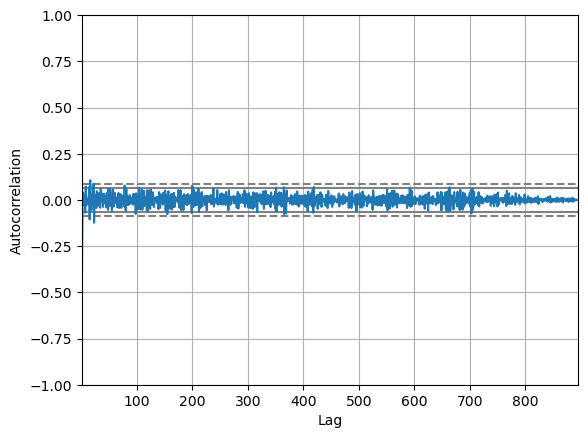

In [57]:
autocorrelation_plot(NYL_Final_ts_fill_diff)
pyplot.show()

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


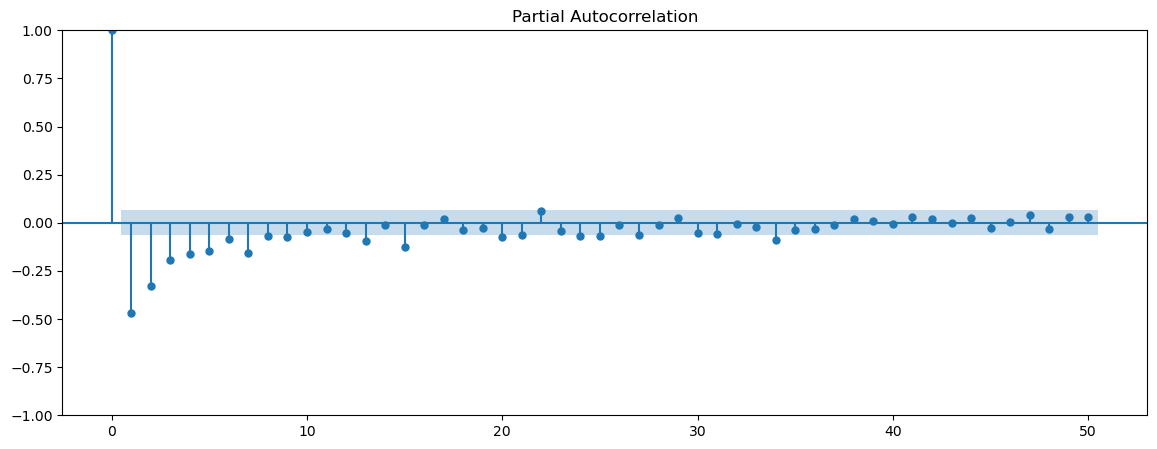

In [59]:
rcParams['figure.figsize'] = 14, 5

plot_pacf(NYL_Final_ts_fill_diff, lags = 50);

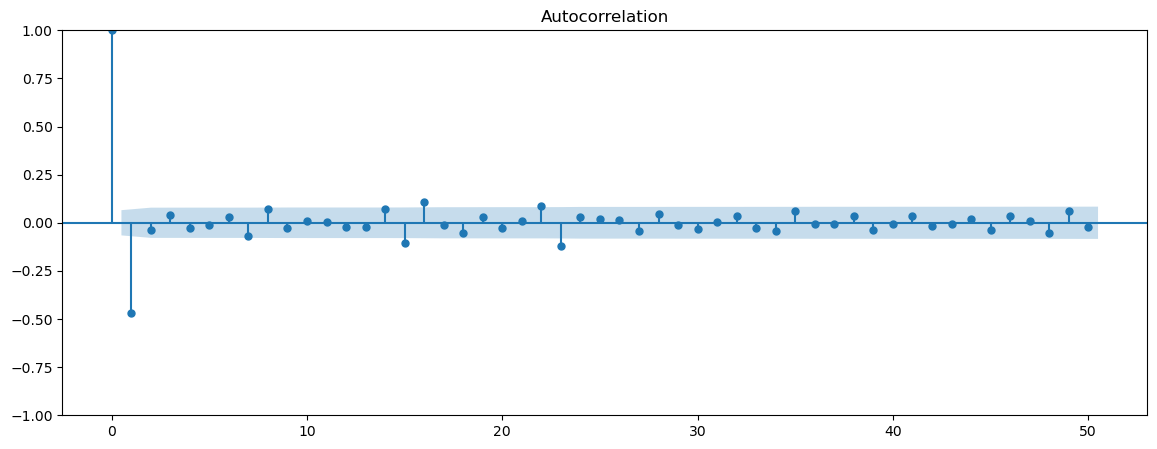

In [60]:
#ACF PLOT
rcParams['figure.figsize'] = 14, 5

plot_acf(NYL_Final_ts_fill_diff, lags = 50);

## Modeling

In [62]:
cutoff = round(NYL_Final_ts_fill_diff.shape[0] * 0.8)
cutoff

716

In [63]:
train = NYL_Final_ts_fill_diff[:cutoff]

test = NYL_Final_ts_fill_diff[cutoff:]

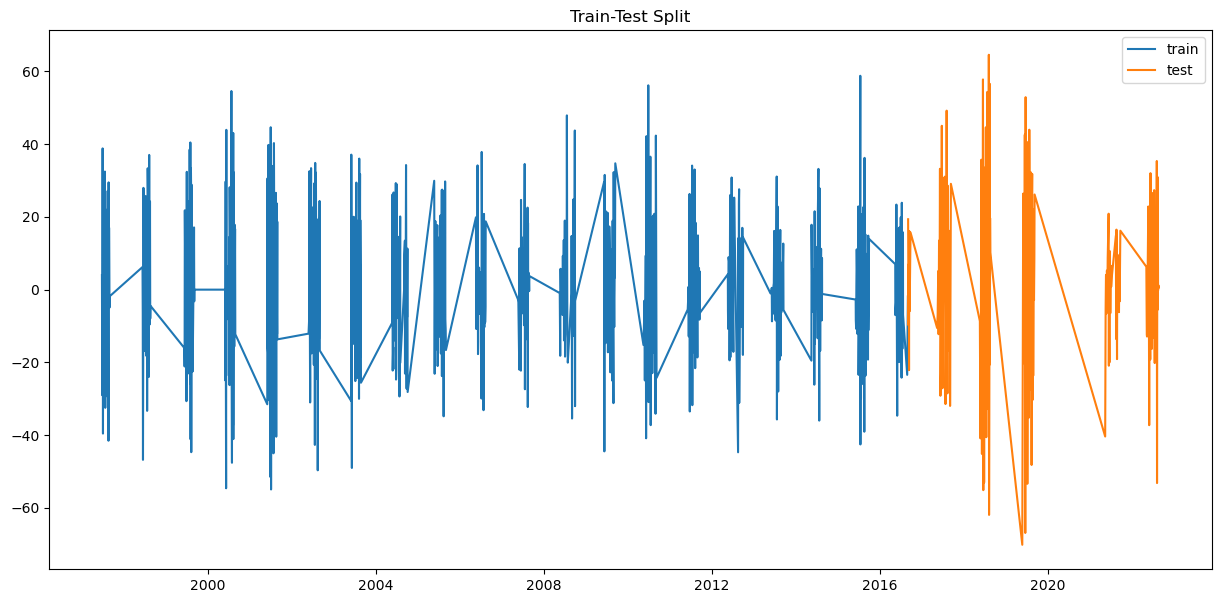

In [65]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(train, label = 'train')
ax.plot(test, label = 'test')
ax.set_title('Train-Test Split');
plt.legend();

In [66]:
train

,Attendance
Date,
1997-06-23,4.011636
1997-06-26,-29.023357
1997-06-29,38.837698
1997-07-02,-39.576001
1997-07-04,7.422279
...,...
2016-07-17,7.155405
2016-07-20,15.756724
2016-07-21,-6.959658


In [67]:
naive = train.shift(1)
naive

,Attendance
Date,
1997-06-23,NaN
1997-06-26,4.011636
1997-06-29,-29.023357
1997-07-02,38.837698
1997-07-04,-39.576001
...,...
2016-07-17,-16.253702
2016-07-20,7.155405
2016-07-21,15.756724


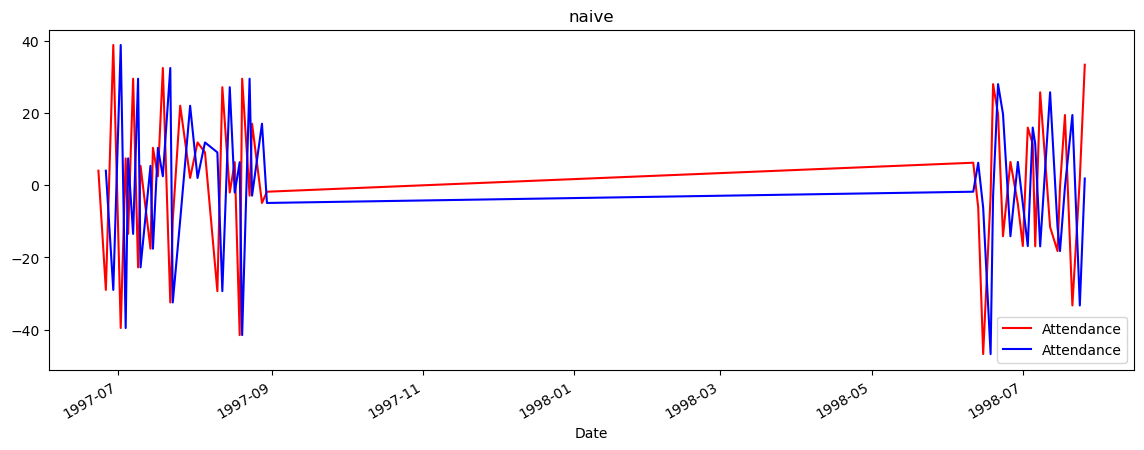

In [68]:
fig, ax = plt.subplots()

train[0:50].plot(ax = ax, c = 'r', label = 'original')
naive[0:50].plot(ax = ax, c = 'b', label = 'shifted')
ax.set_title('naive')
ax.legend();

In [69]:
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

32.54292033522716

In [70]:
att_ar_17 = ARIMA(train, order = (17, 0, 0)).fit()
att_ar_17.predict()

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
1997-06-23    -0.017316
1997-06-26    -1.886411
1997-06-29    16.299146
1997-07-02   -14.343757
1997-07-04    17.026360
                ...    
2016-07-17     2.412227
2016-07-20    -6.454510
2016-07-21   -15.955852
2016-08-26    -7.490965
2016-09-01    10.383169
Name: predicted_mean, Length: 716, dtype: float64

In [71]:
att_ar_17.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Attendance   No. Observations:                  716
Model:                ARIMA(17, 0, 0)   Log Likelihood               -2941.746
Date:                Tue, 28 Mar 2023   AIC                           5921.493
Time:                        16:40:32   BIC                           6008.392
Sample:                             0   HQIC                          5955.049
                                - 716                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0173      0.084     -0.206      0.837      -0.182       0.148
ar.L1         -0.7890      0.036    -21.822      0.000      -0.860      -0.718
ar.L2         -0.6828      0.049    -13.963      0.000      -0.779      -0.587
ar.L3         -0.5806      0.055    -10.586      0.000      -0.688      -0.473
ar.L4         -0.5208      0.058     -9.022      0.000      -0.634      -0.408
ar.L5         -0.4580      0.059     -7.705      0.000      -0.575      -0.342
ar.L6         -0.4270      0.059     -7.243      0.000      -0.543      -0.311
ar.L7         -0.3973      0.060     -6.617      0.000      -0.515      -0.280
ar.L8         -0.3239      0.066     -4.894      0.000      -0.454      -0.194
ar.L9         -0.3125      0.065     -4.834      0.000      -0.439      -0.186
ar.L10        -0.2255      0.064     -3.498      0.000      -0.352      -0.099
ar.L11        -0.2653      0.060     -4.458      0.000      -0.382      -0.149
ar.L12        -0.2463      0.061     -4.059      0.000      -0.365      -0.127
ar.L13        -0.2290      0.060     -3.819      0.000      -0.346      -0.111
ar.L14        -0.1343      0.056     -2.410      0.016      -0.244      -0.025
ar.L15        -0.1468      0.053     -2.753      0.006      -0.251      -0.042
ar.L16        -0.0482      0.046     -1.055      0.291      -0.138       0.041
ar.L17        -0.0334      0.037     -0.899      0.368      -0.106       0.039
sigma2       216.3858     10.144     21.331      0.000     196.503     236.268
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.64
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
y_hat_ar17 = att_ar_17.predict()
ar17_rmse = np.sqrt(mean_squared_error(train, y_hat_ar17))

In [73]:
train.index

DatetimeIndex(['1997-06-23', '1997-06-26', '1997-06-29', '1997-07-02',
               '1997-07-04', '1997-07-05', '1997-07-07', '1997-07-09',
               '1997-07-10', '1997-07-14',
               ...
               '2016-07-06', '2016-07-08', '2016-07-10', '2016-07-13',
               '2016-07-15', '2016-07-17', '2016-07-20', '2016-07-21',
               '2016-08-26', '2016-09-01'],
              dtype='datetime64[ns]', name='Date', length=716, freq=None)

In [74]:
train_with_ind = train.reset_index()
train_with_ind.head()

,Date,Attendance
0,1997-06-23,4.011636
1,1997-06-26,-29.023357
2,1997-06-29,38.837698
3,1997-07-02,-39.576001
4,1997-07-04,7.422279


In [75]:
split = TimeSeriesSplit()
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog = train_with_ind.iloc[train_ind, -1], order = (17, 0, 0)).fit()
    preds = ar.predict(start = val_ind[0], end = val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

23.460327942008398
16.54706940028915
16.754644587879916
17.993635592723408
16.55192299566239


In [76]:
att_ar_17.arparams

array([-0.78904743, -0.68275515, -0.58055949, -0.52075543, -0.4580104 ,
       -0.42698726, -0.3972795 , -0.3238833 , -0.31251535, -0.2254811 ,
       -0.26533155, -0.24634634, -0.22895309, -0.13430796, -0.14678145,
       -0.04824136, -0.03343067])

In [77]:
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1, 1), train[1:].diff().dropna())
print(lr.coef_)

[[-0.65124093]]


In [78]:
att_ma_3 = ARIMA(train, order = (0, 0, 3)).fit()
att_ma_3.predict()

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
1997-06-23    -0.026972
1997-06-26    -1.880137
1997-06-29    15.804303
1997-07-02   -14.302324
1997-07-04    17.748396
                ...    
2016-07-17     1.258167
2016-07-20    -5.731366
2016-07-21   -18.161424
2016-08-26   -11.047550
2016-09-01     8.355585
Name: predicted_mean, Length: 716, dtype: float64

In [79]:
att_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Attendance   No. Observations:                  716
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -2935.954
Date:                Tue, 28 Mar 2023   AIC                           5881.909
Time:                        16:45:30   BIC                           5904.777
Sample:                             0   HQIC                          5890.739
                                - 716                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0270      0.024     -1.126      0.260      -0.074       0.020
ma.L1         -0.8374      0.035    -23.903      0.000      -0.906      -0.769
ma.L2         -0.0594      0.048     -1.235      0.217      -0.154       0.035
ma.L3         -0.0615      0.037     -1.645      0.100      -0.135       0.012
sigma2       212.6789     10.061     21.138      0.000     192.959     232.399
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 8.33
Prob(Q):                              0.95   Prob(JB):                         0.02
Heteroskedasticity (H):               0.59   Skew:                            -0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
y_hat_ma3 = att_ma_3.predict()
ma3_rmse = np.sqrt(mean_squared_error(train, y_hat_ma3))

In [81]:
print(f'AR17 AIC:         {att_ar_17.aic}')
print(f'MA3 AIC:         {att_ma_3.aic}')

AR17 AIC:         5921.492575446262
MA3 AIC:         5881.908657503083


In [82]:
print(f'AR17 RMSE:         {ar17_rmse}')
print(f'MA3 RMSE:         {ma3_rmse}')

AR17 RMSE:         14.731455234563851
MA3 RMSE:         14.616193294066298


In [83]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog = train_with_ind.iloc[train_ind, -1], order = (0, 0, 3)).fit()
    preds = ar.predict(start = val_ind[0], end = val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

23.403861823767073
16.793819670736152
16.61949297986416
17.99455773045484
16.69273555073405


In [84]:
p = d = q = range(0, 2)

pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [85]:
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(NYL_Final_ts_fill_diff,
                                            order = comb,
                                            seasonal_order = combs,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.43203D+00    |proj g|=  5.25328D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      3      1     0     0   2.455D-07   4.432D+00
  F =   4.4320310006951020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=7935.335491244233
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  4.36358D+00    |proj g|=  3.36632D-02

At iterate   10    f=  4.35990D+00    |proj g|=  1.22799D-01

At iterate   15    f=  4.34031D+00    |proj g|=  2.52641D-02

At iterate   20    f=  4.34022D+00    |proj g|=  2.10476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     32      1     0     0   2.105D-05   4.340D+00
  F =   4.3402190389569482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=7774.992079732937
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  4.48245D+00    |proj g|=  1.40876D-02

At iterate   10    f=  4.48015D+00    |proj g|=  2.65628D-01

At iterate   15    f=  4.47836D+00    |proj g|=  2.51374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     30      1     1     0   4.849D-07   4.478D+00
  F =   4.4783629761723143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 1, 0, 12): AIC Calculated=8020.269727348442
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.10474D+00    |proj g|=  1.70333D-01

At iterate   15    f=  4.09094D+00    |proj g|=  1.04853D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     21      1     0     0   1.271D-06   4.091D+00
  F =   4.0909359414417281     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (0, 1, 1, 12): AIC Calculated=7328.775335180693
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.15472D+00    |proj g|=  1.84361D-01

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  4.12007D+00    |proj g|=  7.04489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   1.451D-05   4.120D+00
  F =   4.1200516615292999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 0, 1, 12): AIC Calculated=7382.892474137448
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33947D+00    |proj g|=  1.26660D-01

At iterate    5    f=  4.32053D+00    |proj g|=  2.99630D-02

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.22233D+00    |proj g|=  3.11480D-02

At iterate   10    f=  4.20920D+00    |proj g|=  4.44197D-02

At iterate   15    f=  4.11572D+00    |proj g|=  1.06068D-01

At iterate   20    f=  4.09317D+00    |proj g|=  3.26804D-02

At iterate   25    f=  4.09090D+00    |proj g|=  1.25713D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     50      1     0     0   2.710D-05   4.091D+00
  F =   4.0909018950691447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 1, 1, 12): AIC Calculated=7330.714392173769
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  4.93094D+00    |proj g|=  1.31790D-02

At iterate   10    f=  4.86364D+00    |proj g|=  1.03072D-01

At iterate   15    f=  4.85961D+00    |proj g|=  5.88090D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     25      1     0     0   5.881D-06   4.860D+00
  F =   4.8596108731914089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (0, 1, 1, 12): AIC Calculated=8702.703463012622
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  4.88520D+00    |proj g|=  6.57629D-03

At iterate   10    f=  4.87347D+00    |proj g|=  1.63319D-01

At iterate   15    f=  4.85898D+00    |proj g|=  1.23927D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     21      1     0     0   6.585D-07   4.859D+00
  F =   4.8589779302086624     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 1, 1, 12): AIC Calculated=8703.570495073505
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  4.37128D+00    |proj g|=  2.38592D-02

At iterate   10    f=  4.37121D+00    |proj g|=  8.43088D-02

At iterate   15    f=  4.36641D+00    |proj g|=  8.99114D-02

At iterate   20    f=  4.36380D+00    |proj g|=  4.28813D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     27      1     0     0   4.288D-06   4.364D+00
  F =   4.3637988497738966     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 0, 1, 12): AIC Calculated=7817.199941095276
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   20    f=  4.71499D+00    |proj g|=  1.19432D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     30      1     0     0   7.124D-06   4.715D+00
  F =   4.7149852212771917     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 1, 0, 12): AIC Calculated=8443.823546086172
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.60099D+00    |proj g|=  6.59463D-01

At iterate    5    f=  4.49460D+00    |proj g|=  6.78026D-02


 This problem is unconstrained.



At iterate   10    f=  4.49015D+00    |proj g|=  2.48343D-02

At iterate   15    f=  4.48206D+00    |proj g|=  2.20931D-01

At iterate   20    f=  4.34515D+00    |proj g|=  2.89446D-01

At iterate   25    f=  4.33684D+00    |proj g|=  1.87260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     38      1     0     0   2.199D-06   4.337D+00
  F =   4.3368408244845504     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (0, 1, 1, 12): AIC Calculated=7768.945075827345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  4.37798D+00    |proj g|=  4.03564D-01

At iterate   20    f=  4.37396D+00    |proj g|=  4.74479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     33      1     0     0   2.171D-04   4.374D+00
  F =   4.3739534390989130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 0, 12): AIC Calculated=7835.376655987055
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45821D+00    |proj g|=  4.96305D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.37127D+00    |proj g|=  2.39767D-02

At iterate   10    f=  4.37120D+00    |proj g|=  6.12833D-02

At iterate   15    f=  4.36541D+00    |proj g|=  2.31036D-01

At iterate   20    f=  4.36378D+00    |proj g|=  1.08487D-03

At iterate   25    f=  4.36369D+00    |proj g|=  4.94811D-02

At iterate   30    f=  4.36364D+00    |proj g|=  4.04369D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     55      1     0     0   4.044D-05   4.364D+00
  F =   4.3636383503504446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 12): AIC Calculated=781


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.56771D+00    |proj g|=  4.05769D-01

At iterate   15    f=  4.53867D+00    |proj g|=  3.70784D-01

At iterate   20    f=  4.51360D+00    |proj g|=  8.18069D-02

At iterate   25    f=  4.50584D+00    |proj g|=  4.11694D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     38      1     0     0   8.261D-06   4.506D+00
  F =   4.5058377329674846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 1) x (1, 1, 0, 12): AIC Calculated=8071.449542011797
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.53294D+00    |proj g|=  5.75212D-02

At iterate   10    f=  4.49289D+00    |proj g|=  1.73953D-01

At iterate   15    f=  4.47766D+00    |proj g|=  4.43675D-01

At iterate   20    f=  4.34333D+00    |proj g|=  4.02800D-01

At iterate   25    f=  4.33696D+00    |proj g|=  3.67092D-02

At iterate   30    f=  4.33684D+00    |proj g|=  2.61499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     58      1     0     0   2.615D-04   4.337D+00
  F =   4.3368373778283695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 12): AIC Calculated=777

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  4.31613D+00    |proj g|=  3.62447D-02

At iterate   10    f=  4.22200D+00    |proj g|=  1.32577D-01

At iterate   15    f=  4.21882D+00    |proj g|=  1.40728D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     25      1     0     0   2.575D-06   4.219D+00
  F =   4.2188158886661835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (0, 1, 1, 12): AIC Calculated=7557.680440712469
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.42181D+00    |proj g|=  1.27472D-02

At iterate    5    f=  4.40286D+00    |proj g|=  5.89191D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   3.022D-06   4.401D+00
  F =   4.4009261735709364     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 1, 0, 12): AIC Calculated=7883.657850691977
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.31754D+00    |proj g|=  3.24429D-02

At iterate   10    f=  4.30690D+00    |proj g|=  1.81260D-01

At iterate   15    f=  4.22749D+00    |proj g|=  1.70618D-01

At iterate   20    f=  4.21872D+00    |proj g|=  1.40338D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     76      2     0     0   2.054D-05   4.219D+00
  F =   4.2186922550536394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 1, 12): AIC Calculated=7559.459136546015
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.19873D+00    |proj g|=  1.88427D-01

At iterate    5    f=  4.17800D+00    |proj g|=  1.21013D-02

At iterate   10    f=  4.17734D+00    |proj g|=  5.04177D-02

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     42      1     0     0   4.345D-05   4.462D+00
  F =   4.4619235685387162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 0, 12): AIC Calculated=7992.843187684302
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24872D+00    |proj g|=  1.24852D-01

At iterate    5    f=  4.21775D+00    |proj g|=  2.22035D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.18195D+00    |proj g|=  1.60756D-01

At iterate   15    f=  4.08837D+00    |proj g|=  3.71932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   5.427D-06   4.088D+00
  F =   4.0883498670181382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (0, 1, 1, 12): AIC Calculated=7326.146261962467
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.14620D+00    |proj g|=  1.87214D-01

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   6.002D-05   4.117D+00
  F =   4.1168974719786124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 1, 12): AIC Calculated=7379.246474841717
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.33226D+00    |proj g|=  1.28280D-01
  ys=-3.363E-03  -gs= 7.639E-03 BFGS update SKIPPED


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.30865D+00    |proj g|=  2.52288D-02

At iterate   10    f=  4.28070D+00    |proj g|=  1.29464D-01

At iterate   15    f=  4.26513D+00    |proj g|=  9.01271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     37      1     1     0   4.352D-06   4.265D+00
  F =   4.2650918475617052     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 1) x (1, 1, 0, 12): AIC Calculated=7642.514407135452


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28099D+00    |proj g|=  1.20349D-01

At iterate    5    f=  4.22069D+00    |proj g|=  3.31200D-02

At iterate   10    f=  4.17733D+00    |proj g|=  1.48558D-01

At iterate   15    f=  4.08848D+00    |proj g|=  5.07419D-02

At iterate   20    f=  4.08831D+00    |proj g|=  5.70508D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   4.241D-06   4.088D+00
  F =   4.0883143159551940     

CONVERG

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  4.69367D+00    |proj g|=  1.78657D-02

At iterate   10    f=  4.62231D+00    |proj g|=  2.40667D-01

At iterate   15    f=  4.59345D+00    |proj g|=  9.52581D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   2.720D-06   4.593D+00
  F =   4.5934455196926161     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 1, 1, 12): AIC Calculated=8228.267480249782
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

ARIMA (1, 1, 0) x (1, 0, 0, 12): AIC Calculated=8295.007519569584
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.63090D+00    |proj g|=  1.66702D-02

At iterate    5    f=  4.63070D+00    |proj g|=  1.51891D-02

At iterate   10    f=  4.63061D+00    |proj g|=  6.60841D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   6.608D-05   4.631D+00
  F =   4.6306084226744018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIM

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.69313D+00    |proj g|=  1.26765D-02

At iterate   10    f=  4.67359D+00    |proj g|=  1.52201D-01

At iterate   15    f=  4.59593D+00    |proj g|=  8.45063D-02

At iterate   20    f=  4.59314D+00    |proj g|=  7.57403D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   7.574D-06   4.593D+00
  F =   4.5931425242000987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 1, 1, 12): AIC Calculated=8229.725118318176
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  4.26928D+00    |proj g|=  4.40112D-02

At iterate   10    f=  4.26918D+00    |proj g|=  8.62616D-02

At iterate   15    f=  4.26756D+00    |proj g|=  2.65333D-01

At iterate   20    f=  4.24567D+00    |proj g|=  2.70322D-01

At iterate   25    f=  4.24511D+00    |proj g|=  9.82654D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   9.827D-06   4.245D+00
  F =   4.2451096438646001     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (0, 0, 1, 12): AIC Calculated=7606.746262517635
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  4.60503D+00    |proj g|=  1.62819D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     37      1     0     0   6.155D-07   4.605D+00
  F =   4.6049087823504360     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (0, 1, 0, 12): AIC Calculated=8248.78672040728
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45735D+00    |proj g|=  1.97641D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.42037D+00    |proj g|=  6.79860D-02

At iterate   10    f=  4.40301D+00    |proj g|=  1.38377D-01

At iterate   15    f=  4.22704D+00    |proj g|=  3.84352D-01

At iterate   20    f=  4.21473D+00    |proj g|=  3.02256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     34      1     0     0   1.055D-04   4.215D+00
  F =   4.2147335975648579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 1, 12): AIC Calculated=7552.373139641095
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  4.27247D+00    |proj g|=  2.94194D-01

At iterate   15    f=  4.25713D+00    |proj g|=  4.40519D-01

At iterate   20    f=  4.24889D+00    |proj g|=  3.97983D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   8.880D-06   4.249D+00
  F =   4.2488867420052454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 1) x (1, 0, 0, 12): AIC Calculated=7613.50726818939
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At i

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.26924D+00    |proj g|=  4.43658D-02

At iterate   10    f=  4.26915D+00    |proj g|=  8.40598D-02

At iterate   15    f=  4.26477D+00    |proj g|=  3.67789D-01

At iterate   20    f=  4.24549D+00    |proj g|=  2.00704D-01

At iterate   25    f=  4.24506D+00    |proj g|=  1.13776D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   2.198D-04   4.245D+00
  F =   4.2450624551279983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 1, 12): AIC Calculated=7608.6617946791175
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.49702D+00    |proj g|=  2.66904D-01

At iterate   10    f=  4.48717D+00    |proj g|=  2.46702D-01

At iterate   15    f=  4.40614D+00    |proj g|=  2.18916D-01

At iterate   20    f=  4.40003D+00    |proj g|=  3.26860D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   8.651D-05   4.400D+00
  F =   4.4000315497102909     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 0, 12): AIC Calculated=7884.05647398142
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =          

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  4.43217D+00    |proj g|=  1.70422D-01

At iterate   10    f=  4.41373D+00    |proj g|=  8.97035D-02

At iterate   15    f=  4.40650D+00    |proj g|=  1.54130D-01

At iterate   20    f=  4.36934D+00    |proj g|=  2.81609D-01

At iterate   25    f=  4.21681D+00    |proj g|=  9.96549D-02

At iterate   30    f=  4.21472D+00    |proj g|=  9.88772D-03

At iterate   35    f=  4.21472D+00    |proj g|=  2.49999D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     61      1     0     0   2.500D-05   4.215D+00
  F =   4.2147156144559261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [86]:
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 0, 1)
pdqs    (0, 1, 1, 12)
aic       7326.146262
Name: 43, dtype: object

## Results

In [87]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(NYL_Final_ts_fill_diff, 
                                        order = (1, 0, 1), 
                                        seasonal_order = (0, 1, 1, 12), 
                                        enforce_stationarity = False, 
                                        enforce_invertibility = False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.24872D+00    |proj g|=  1.24852D-01

At iterate    5    f=  4.21775D+00    |proj g|=  2.22035D-02

At iterate   10    f=  4.18195D+00    |proj g|=  1.60756D-01

At iterate   15    f=  4.08837D+00    |proj g|=  3.71932D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   5.427D-06   4.088D+00
  F =   4.0883498670181382     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

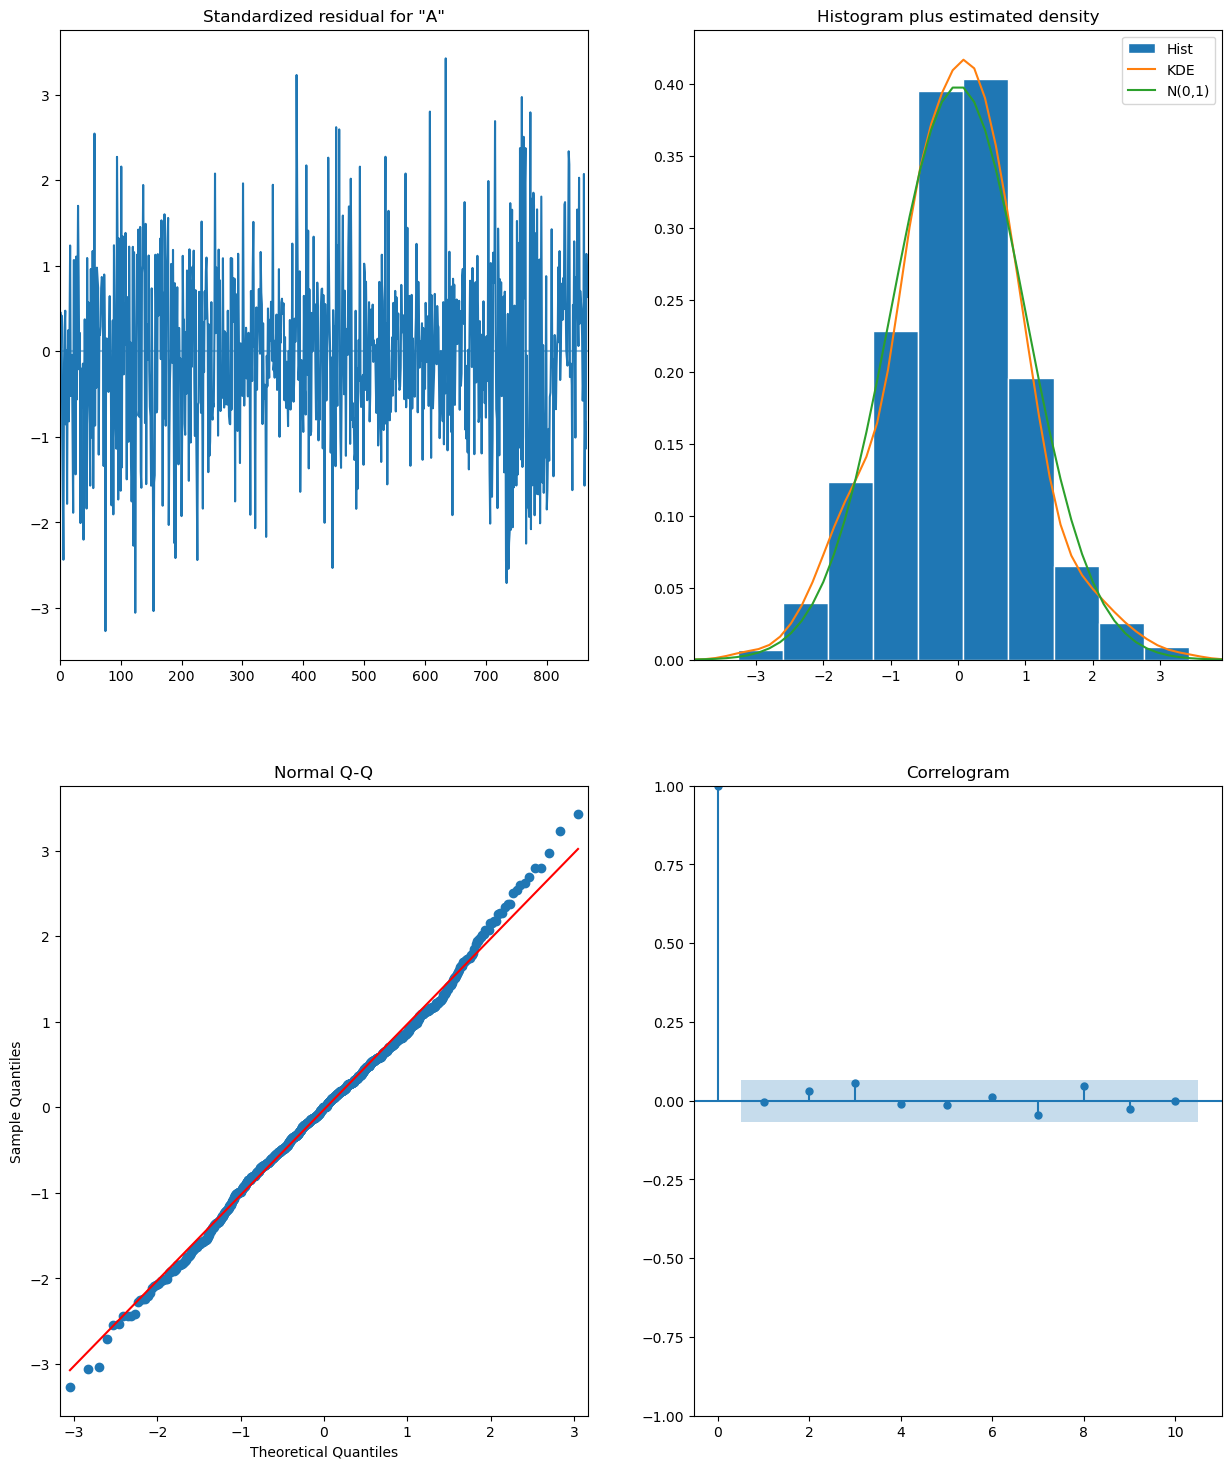

In [88]:
output.plot_diagnostics(figsize = (15, 18))
plt.show()

In [100]:
pred = output.get_prediction(start = pd.to_datetime('1997-06-23'), dynamic = False)
pred_conf = pred.conf_int()

In [102]:
NYL_Final_ts.isnull().count()

Attendance    896
dtype: int64

In [105]:
NYL_Final_ts_fill_diff['1997':]

,Attendance
Date,
1997-06-23,4.011636
1997-06-26,-29.023357
1997-06-29,38.837698
1997-07-02,-39.576001
1997-07-04,7.422279
...,...
2022-08-12,-5.585717
2022-08-14,30.936157
2022-08-17,-0.213017


In [106]:
pred.predicted_mean

Date
1997-06-23     0.000000
1997-06-26     0.178264
1997-06-29    -1.281184
1997-07-02     1.668239
1997-07-04    -1.683830
                ...    
2022-08-12    12.644177
2022-08-14    12.692361
2022-08-17   -12.531482
2022-08-20    -8.969948
2022-08-23   -11.821043
Name: predicted_mean, Length: 895, dtype: float64

In [108]:
pred_conf.iloc[:, 0]

Date
1997-06-23   -2771.807649
1997-06-26   -2774.539661
1997-06-29   -2776.133009
1997-07-02   -2773.183851
1997-07-04   -2776.535920
                 ...     
2022-08-12     -18.727896
2022-08-14     -18.679549
2022-08-17     -43.903259
2022-08-20     -40.341618
2022-08-23     -43.192625
Name: lower Attendance, Length: 895, dtype: float64

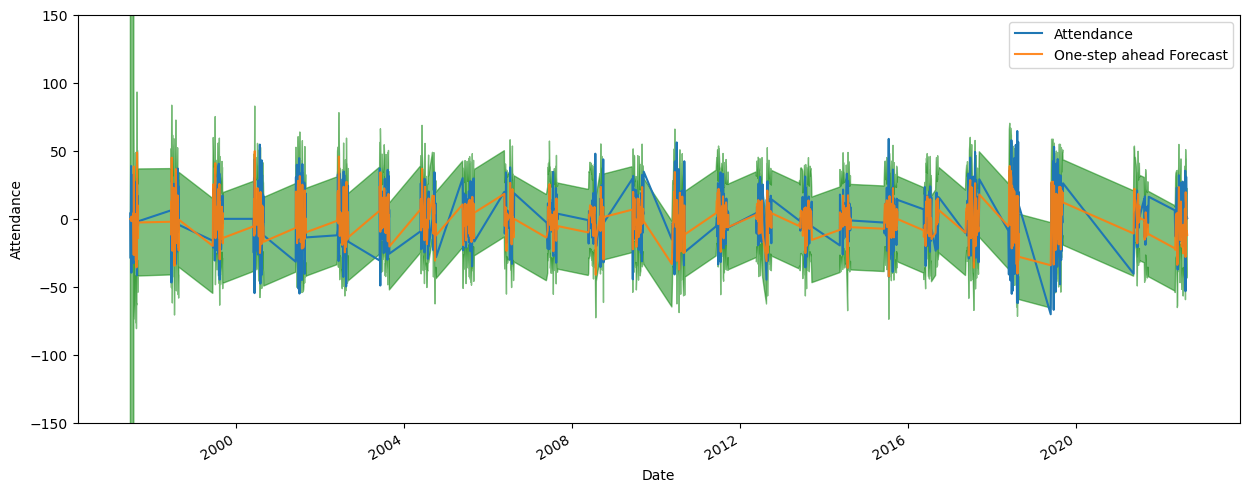

In [112]:
rcParams['figure.figsize'] = 15, 6

ax = NYL_Final_ts_fill_diff['1997':].plot(label = 'observed')

pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color = 'g', alpha = 0.5)

plt.ylim(-150, 150)

ax.set_xlabel('Date')
ax.set_ylabel('Attendance')
plt.legend()

plt.show()

In [133]:
Att_forecasted = pred.predicted_mean
Att_truth = NYL_Final_ts_fill_diff['1997-06-23':]

# Compute the mean square error
mse = ((Att_truth.iloc[:,0] - preds) **2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 277.7


## Conclusion